In [76]:
# Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import pearsonr, spearmanr
from scipy.stats import contingency
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import joblib
import matplotlib.pyplot as plt
import subprocess

In [77]:
cmd = "aws s3 cp s3://taxdatalake/RAW/DCS_Item_Extract_Report C:\\Users\\user\\OneDrive\\EAFIT\\MAESTRÍA_EN_CIENCIA_DE_DATOS\\PROYECTO_INTEGRADOR\\BUCKET_PROJECT\\MODEL\\ --no-sign-request"

# Run the command
subprocess.run(cmd, shell=True)

CompletedProcess(args='aws s3 cp s3://taxdatalake/RAW/DCS_Item_Extract_Report C:\\Users\\user\\OneDrive\\EAFIT\\MAESTRÍA_EN_CIENCIA_DE_DATOS\\PROYECTO_INTEGRADOR\\BUCKET_PROJECT\\MODEL\\ --no-sign-request', returncode=0)

In [78]:
path = r'C:\\Users\\user\\OneDrive\\EAFIT\\MAESTRÍA_EN_CIENCIA_DE_DATOS\\PROYECTO_INTEGRADOR\\BUCKET_PROJECT\\MODEL\\DCS_Item_Extract_Report'
df = pd.read_excel(path,header = 1)

In [79]:
df.head(3)

,Unnamed: 0,ITEM NO,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
0,NaN,1,NaN,1C,12,SKIN GRAFT PRODUCTS,21,EXTERNAL FRACTURE MGMT,500.0,SURGICAL,...,SURGICAL PRODUCTS,934,SERVICE AND REPAIR,01478,REPAIRS,B8TU,ATS LABOR AND REPAIR,NaN,SSI,N
1,NaN,2,N5,1A,0,UNASSIGNED,45,CAS PRODUCTS,200.0,KNEES,...,CAS ORTHOSOFT DISPOSABLES,09D,ROSA KNEE,01484,ROSA KNEE DISPOSABLES,B66G,ROSA TKA DISPOSABLE,NaN,FGM,INI
2,NaN,3,N5,1A,41,OTHER TOTAL JOINTS,17,OTHER TOTAL JOINT,350.0,FOOT ANKLE,...,DISPOSABLE,0E2,BIOMET CANNULATED SCREWS,01700,BIOMET CANNULATED SCREWS,B2LH,BCS DISPOSABLES 2,NaN,FGM,INI


In [80]:
# Removed first column
df_Remove = df.iloc[0:, 1:]

In [81]:
df_Remove.head(3)

,ITEM NO,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,APPLICATION CDE,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
0,1,NaN,1C,12,SKIN GRAFT PRODUCTS,21,EXTERNAL FRACTURE MGMT,500.0,SURGICAL,38.0,...,SURGICAL PRODUCTS,934,SERVICE AND REPAIR,01478,REPAIRS,B8TU,ATS LABOR AND REPAIR,NaN,SSI,N
1,2,N5,1A,0,UNASSIGNED,45,CAS PRODUCTS,200.0,KNEES,75.0,...,CAS ORTHOSOFT DISPOSABLES,09D,ROSA KNEE,01484,ROSA KNEE DISPOSABLES,B66G,ROSA TKA DISPOSABLE,NaN,FGM,INI
2,3,N5,1A,41,OTHER TOTAL JOINTS,17,OTHER TOTAL JOINT,350.0,FOOT ANKLE,42.0,...,DISPOSABLE,0E2,BIOMET CANNULATED SCREWS,01700,BIOMET CANNULATED SCREWS,B2LH,BCS DISPOSABLES 2,NaN,FGM,INI


# <CENTER> **EDA** </CENTER>

In [82]:
n_tax_codes = df_Remove['VERTEX PROD ID'].unique()

In [83]:
Vertex_dist = df_Remove['VERTEX PROD ID'].value_counts()
Vertex_dist = Vertex_dist.sort_values(ascending=False)
print('Number of Vertex Categories unfiltered: ',len(Vertex_dist))
filtered_dist = Vertex_dist[Vertex_dist >= 50]
print('Number of filtered items with frequency higher than forty items: ',len(filtered_dist))
filtered_dist.head(10)

Number of Vertex Categories unfiltered:  144
Number of filtered items with frequency higher than forty items:  52


VERTEX PROD ID
48Y    9798
38N    9005
37N    6697
65Y    6015
14N    5389
47Y    2951
41Y    2671
06N    2139
41N    1707
12Y    1552
Name: count, dtype: int64

In [84]:
cum_dist_Vertex = Vertex_dist.sort_values()
cumulative_sum = Vertex_dist.cumsum()
cumulative_distribution = (cumulative_sum / df_Remove['VERTEX PROD ID'].count())*100
cumulative_distribution.head(52)

VERTEX PROD ID
48Y    15.410264
38N    29.573300
37N    40.106321
65Y    49.566694
14N    58.042497
47Y    62.683821
41Y    66.884761
06N    70.248974
41N    72.933738
12Y    75.374719
40N    77.743351
03D    79.798997
60Y    81.573111
06Y    82.911562
14Y    84.199682
38Y    85.407590
12W    86.538431
75Y    87.611079
07N    88.579922
74Y    89.529891
70N    90.236077
73N    90.865196
71N    91.494314
37Y    92.049512
97Y    92.554379
32Y    93.049810
40Y    93.516931
45Y    93.976188
73Y    94.298611
43Y    94.610025
13Y    94.910429
86Y    95.196678
46Y    95.473491
42N    95.747157
72N    95.984650
07Y    96.201695
46D    96.407732
72Y    96.613768
04N    96.818232
33N    96.995958
43N    97.172111
BNS    97.340400
87N    97.492962
82Y    97.636086
LBR    97.771347
30Y    97.897171
02Y    98.008839
50Y    98.114217
44N    98.218021
44Y    98.318680
83Y    98.402038
84N    98.480678
Name: count, dtype: float64

In [85]:
Vertex_dist = df_Remove['VERTEX PROD ID'].value_counts()
Vertex_dist = Vertex_dist.sort_values(ascending=False)
filtered_dist = Vertex_dist[Vertex_dist >= 100]
print('Total categories:',len(filtered_dist))
filtered_dist.head(10)

Total categories: 42


VERTEX PROD ID
48Y    9798
38N    9005
37N    6697
65Y    6015
14N    5389
47Y    2951
41Y    2671
06N    2139
41N    1707
12Y    1552
Name: count, dtype: int64

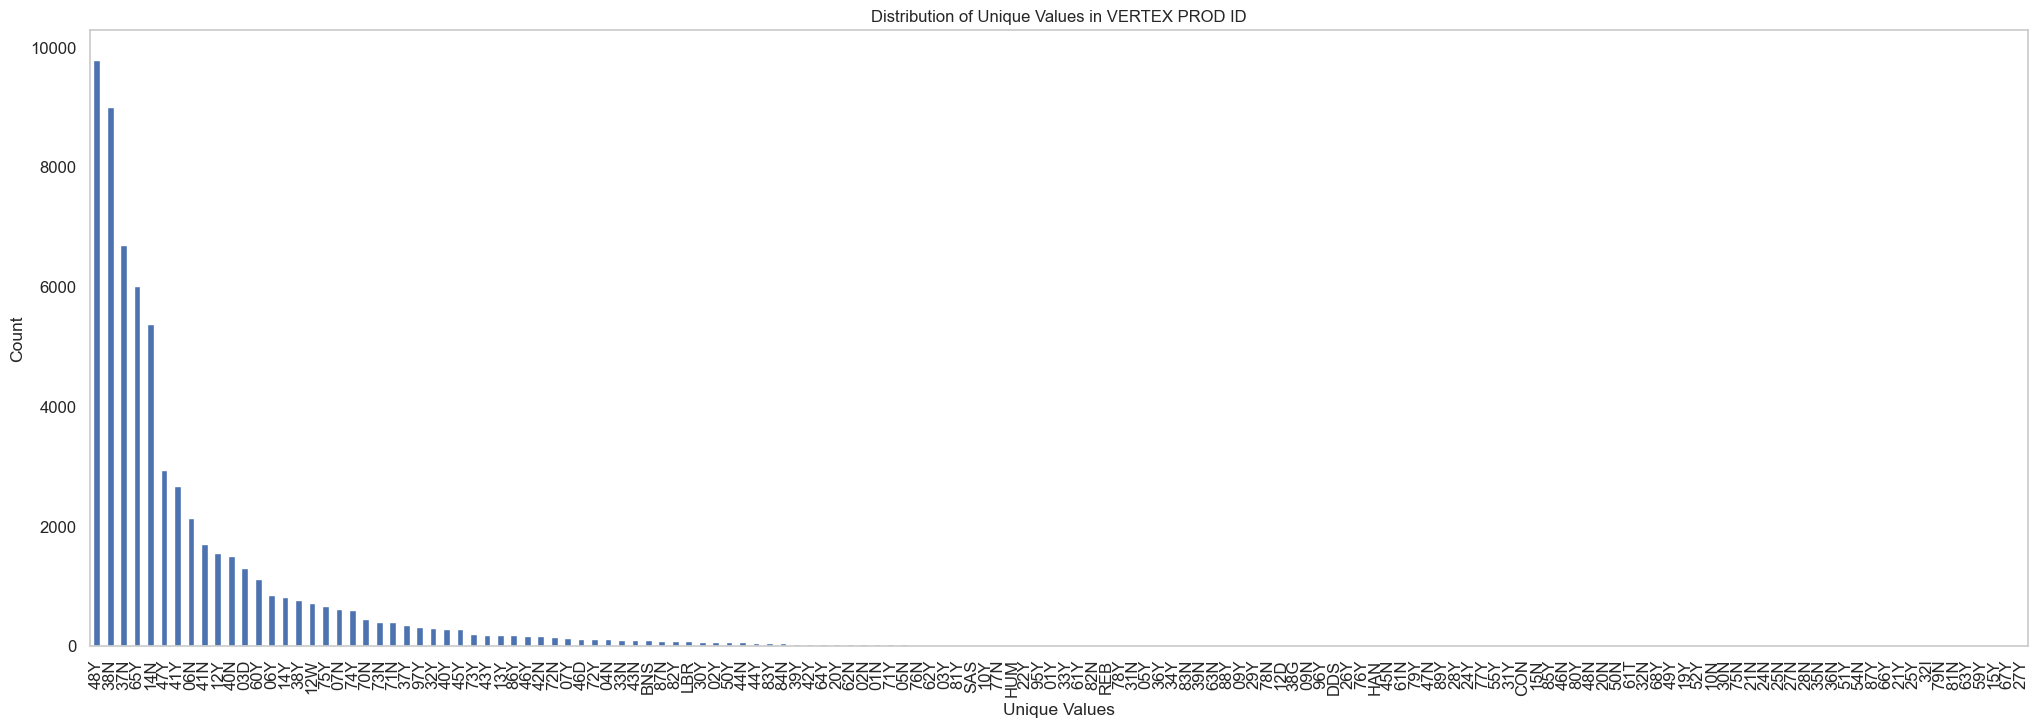

In [86]:
Vertex_dist.plot(kind='bar',figsize=[25,8])

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in VERTEX PROD ID')

# Show the plot
plt.grid()
plt.show()

Total number of unique values is:  80


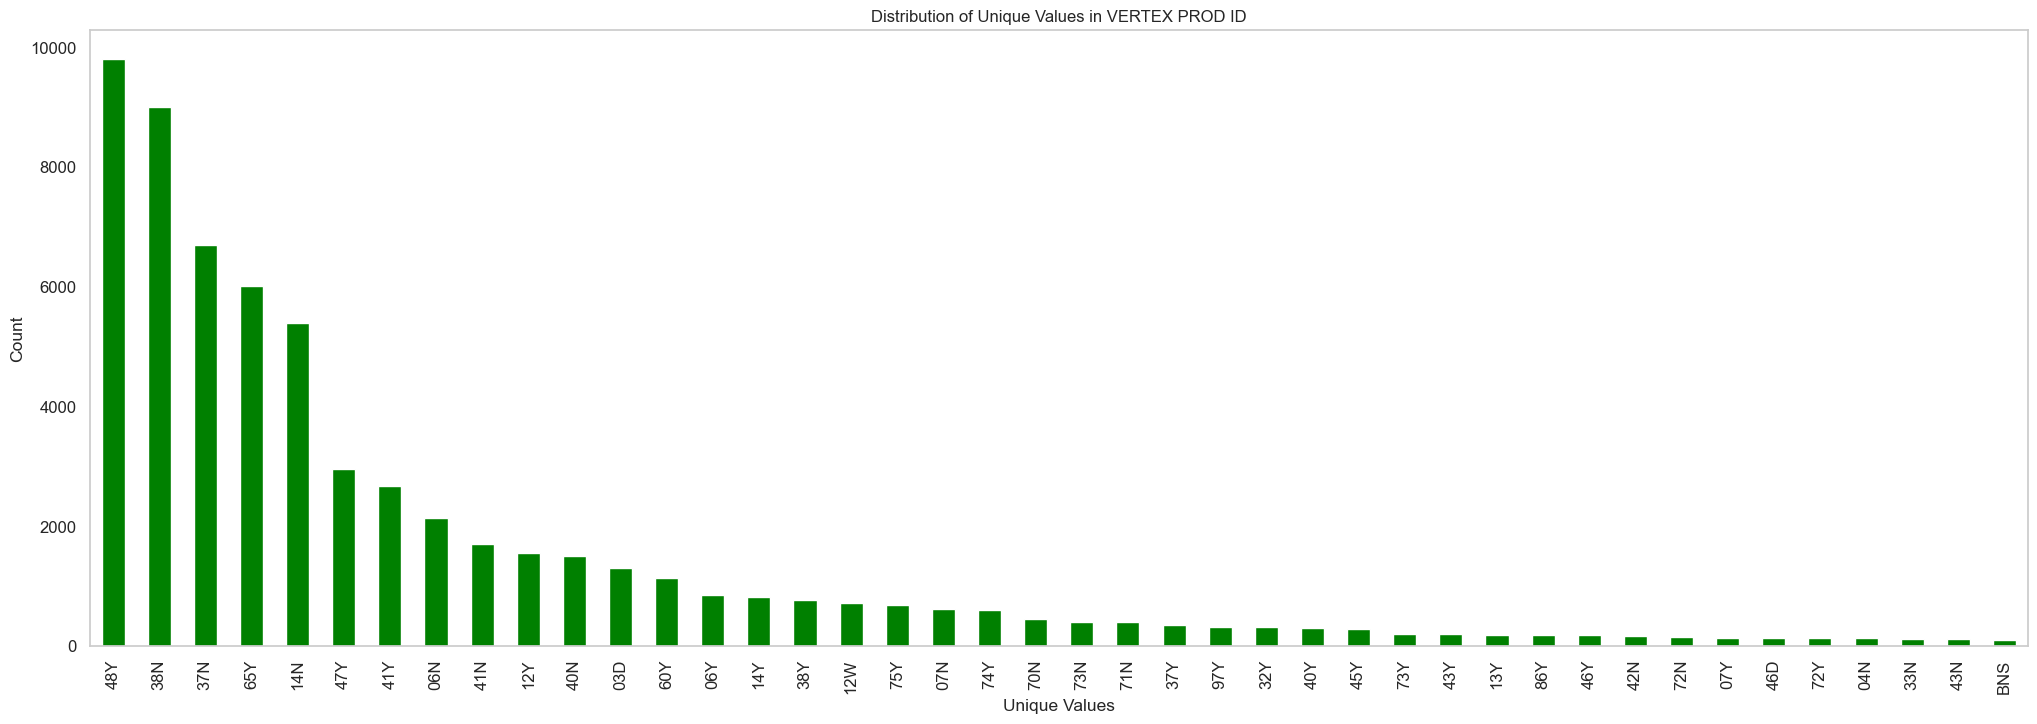

In [87]:
filtered_dist.plot(kind='bar',figsize=[25,8], color='Green')

print('Total number of unique values is: ', Vertex_dist.nunique())

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in VERTEX PROD ID')

# Show the plot
plt.grid()
plt.show()

In [88]:
df_Remove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63645 entries, 0 to 63644
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ITEM NO                  63645 non-null  int64  
 1   DOM RLS CODE             54519 non-null  object 
 2   MANUFACT WHSE            63645 non-null  object 
 3   PRODUCT CLASS            63645 non-null  int64  
 4   PROD CLASS DESC          63645 non-null  object 
 5   ITEM HSE PROD LINE       63645 non-null  int64  
 6   ITEM HSE PROD LINE DESC  63645 non-null  object 
 7   BUSINESS SEGMENT CDE     63626 non-null  float64
 8   BUSINESS SEGMENT DESC    63626 non-null  object 
 9   APPLICATION CDE          62506 non-null  float64
 10  APPLICATION DESC         62506 non-null  object 
 11  PRODUCT TYPE             62506 non-null  object 
 12  PRODUCT TYPE DESC        62506 non-null  object 
 13  PRODUCT GROUP            63626 non-null  float64
 14  PRODUCT GROUP DESC    

In [89]:
# Removed blanks
df_V2 = df_Remove[df_Remove['PROD SUBSYSTEM DESC'].notnull()] #esta columna es la que tiene mas blanks
df_V2 = df_V2[df_V2['VERTEX PROD ID'].notnull()]
df_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62424 entries, 71 to 63639
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ITEM NO                  62424 non-null  int64  
 1   DOM RLS CODE             53779 non-null  object 
 2   MANUFACT WHSE            62424 non-null  object 
 3   PRODUCT CLASS            62424 non-null  int64  
 4   PROD CLASS DESC          62424 non-null  object 
 5   ITEM HSE PROD LINE       62424 non-null  int64  
 6   ITEM HSE PROD LINE DESC  62424 non-null  object 
 7   BUSINESS SEGMENT CDE     62424 non-null  float64
 8   BUSINESS SEGMENT DESC    62424 non-null  object 
 9   APPLICATION CDE          62424 non-null  float64
 10  APPLICATION DESC         62424 non-null  object 
 11  PRODUCT TYPE             62424 non-null  object 
 12  PRODUCT TYPE DESC        62424 non-null  object 
 13  PRODUCT GROUP            62424 non-null  float64
 14  PRODUCT GROUP DESC       6

In [90]:
#Get the column names from column 2 onwards
column_names = df_V2.columns[1:]
column_names

Index(['DOM RLS CODE', 'MANUFACT WHSE', 'PRODUCT CLASS', 'PROD CLASS DESC ',
       'ITEM HSE PROD LINE', 'ITEM HSE PROD LINE DESC', 'BUSINESS SEGMENT CDE',
       'BUSINESS SEGMENT DESC', 'APPLICATION CDE', 'APPLICATION DESC',
       'PRODUCT TYPE', 'PRODUCT TYPE DESC', 'PRODUCT GROUP',
       'PRODUCT GROUP DESC', 'PROD SYSTEM', 'PROD SYSTEM DESC',
       'PROD SUBSYSTEM', 'PROD SUBSYSTEM DESC', 'PROD FAMILY',
       'PROD FAMILY DESC', 'VERTEX PROD ID', 'MANUFACT TYPE CODE',
       'INSTRUMENT DESC'],
      dtype='object')

In [91]:
# Create a dictionary to store label encoders
label_encode = {}
encoded_df = {}

# Fit and transform data, and store label encoders
for i in df_V2.iloc[0: ,1:27]:
    label_encode[i] = LabelEncoder()
    encoded_df[i] = label_encode[i].fit_transform(df_V2[i])

# Display the DataFrame
encoded_df = pd.DataFrame(encoded_df)
encoded_df

,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,APPLICATION CDE,APPLICATION DESC,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
0,18,1,24,45,4,0,20,19,50,60,...,123,53,368,509,653,1351,3375,40,1,11
1,18,1,24,45,4,0,8,17,30,57,...,88,0,239,0,395,3235,1353,40,1,5
2,18,1,80,55,14,12,18,13,47,50,...,93,39,280,495,485,3565,1922,131,1,5
3,18,1,80,55,14,12,18,13,47,50,...,93,39,280,495,485,3562,2638,131,1,5
4,18,0,1,26,1,13,1,7,21,39,...,76,238,153,0,395,3305,1328,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62419,5,0,11,81,5,14,6,6,13,58,...,85,104,329,580,572,3097,3027,21,3,5
62420,5,0,11,81,5,14,5,20,33,61,...,85,347,126,362,188,1615,1216,21,4,5
62421,11,2,9,61,9,3,14,16,31,45,...,113,91,384,645,720,2945,3532,19,4,4
62422,18,2,9,61,9,3,14,16,31,45,...,113,91,384,645,720,2945,3532,19,4,4


In [92]:
#Print encoded DF to visualize it
encoded_df.head(3)

,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,APPLICATION CDE,APPLICATION DESC,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
0,18,1,24,45,4,0,20,19,50,60,...,123,53,368,509,653,1351,3375,40,1,11
1,18,1,24,45,4,0,8,17,30,57,...,88,0,239,0,395,3235,1353,40,1,5
2,18,1,80,55,14,12,18,13,47,50,...,93,39,280,495,485,3565,1922,131,1,5


In [93]:
#Exclude item number column
encoded_df2 = encoded_df.iloc[:, 1:]
columns_encoded = encoded_df2.columns
columns_encoded

Index(['MANUFACT WHSE', 'PRODUCT CLASS', 'PROD CLASS DESC ',
       'ITEM HSE PROD LINE', 'ITEM HSE PROD LINE DESC', 'BUSINESS SEGMENT CDE',
       'BUSINESS SEGMENT DESC', 'APPLICATION CDE', 'APPLICATION DESC',
       'PRODUCT TYPE', 'PRODUCT TYPE DESC', 'PRODUCT GROUP',
       'PRODUCT GROUP DESC', 'PROD SYSTEM', 'PROD SYSTEM DESC',
       'PROD SUBSYSTEM', 'PROD SUBSYSTEM DESC', 'PROD FAMILY',
       'PROD FAMILY DESC', 'VERTEX PROD ID', 'MANUFACT TYPE CODE',
       'INSTRUMENT DESC'],
      dtype='object')

In [94]:
#Transform columns into integer values as most of them are object types.
encoded_df2[columns_encoded] = encoded_df2[columns_encoded].astype(int)
encoded_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62424 entries, 0 to 62423
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   MANUFACT WHSE            62424 non-null  int32
 1   PRODUCT CLASS            62424 non-null  int32
 2   PROD CLASS DESC          62424 non-null  int32
 3   ITEM HSE PROD LINE       62424 non-null  int32
 4   ITEM HSE PROD LINE DESC  62424 non-null  int32
 5   BUSINESS SEGMENT CDE     62424 non-null  int32
 6   BUSINESS SEGMENT DESC    62424 non-null  int32
 7   APPLICATION CDE          62424 non-null  int32
 8   APPLICATION DESC         62424 non-null  int32
 9   PRODUCT TYPE             62424 non-null  int32
 10  PRODUCT TYPE DESC        62424 non-null  int32
 11  PRODUCT GROUP            62424 non-null  int32
 12  PRODUCT GROUP DESC       62424 non-null  int32
 13  PROD SYSTEM              62424 non-null  int32
 14  PROD SYSTEM DESC         62424 non-null  int32
 15  PR

In [95]:
# Calculate correlational matrix
correlation_matrix = encoded_df2.corr()

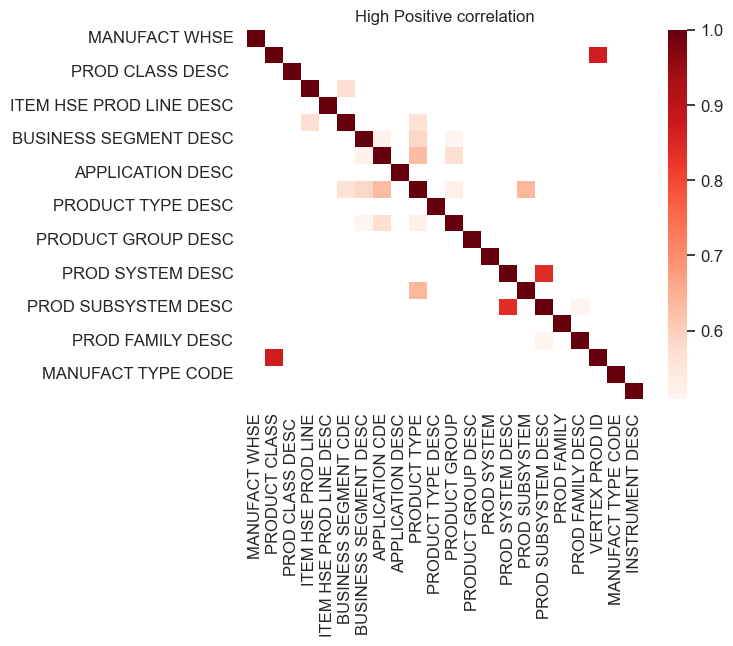

In [96]:
#filtro de la matrix
high_corr = correlation_matrix[correlation_matrix>=.50]

#plt.figure(figsize=(12,8))
sns.heatmap(high_corr, cmap='Reds')
plt.title('High Positive correlation')
plt.grid();

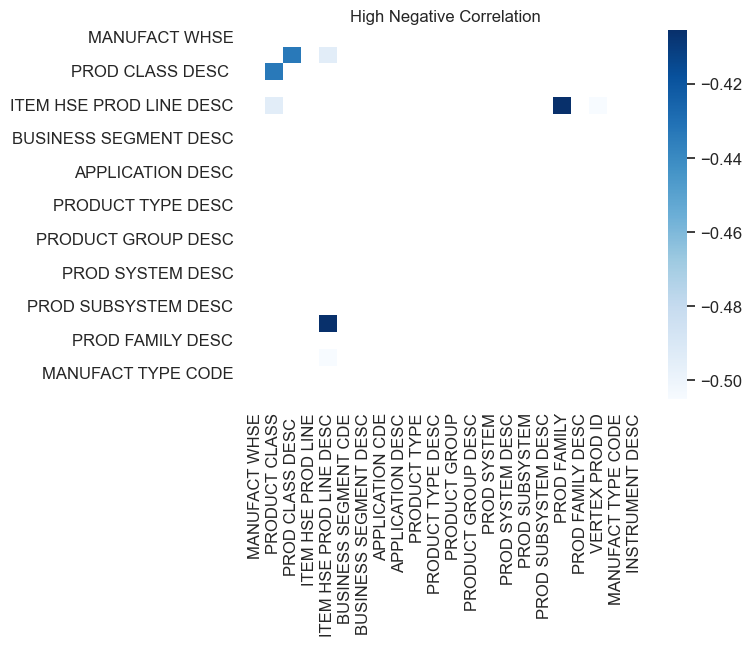

In [97]:
#filtro de la matrix
low_corr = correlation_matrix[correlation_matrix<=-0.40]

#plt.figure(figsize=(12,8))
sns.heatmap(low_corr, cmap='Blues')
plt.title('High Negative Correlation')
plt.grid();

# <CENTER> **RANDOM FOREST DE BASE** </CENTER>

In [98]:
X = encoded_df2.drop('VERTEX PROD ID', axis = 1)
y = encoded_df2['VERTEX PROD ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf = clf.fit(X_train, y_train)

# Realizar predicciones
y_pred = clf.predict(X_test)

# Calcular la precisión del clasificador
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Precisión del clasificador: {accuracy:.2f}")

# Escribir el informe en una variable
reportRF = classification_report(y_test, y_pred, zero_division=float('NaN'))
print("\nReporte de clasificación:")
print(reportRF)
 
# Escribir el informe en un archivo
with open('ReportRF.txt', 'w') as file:
    file.write(reportRF)

Precisión del clasificador: 0.79

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        13
           4       0.93      0.94      0.93       252
           5       1.00      0.50      0.67         4
           6       0.70      0.21      0.32        34
           7       1.00      1.00      1.00         7
           8       0.00       nan       nan         0
           9       1.00      0.99      0.99       423
          10       0.97      0.99      0.98       176
          11       0.82      0.98      0.89       127
          12       0.95      0.95      0.95        20
          14       1.00      1.00      1.00         1
          15       0.00       nan       nan         0
          16       1.00      0.75      0.86         4
          17       1.

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


---
---
# <CENTER>**REDISTRIBUCIÓN DE DATOS**</CENTER>

In [100]:
# Removed blanks
df_V2 = df_Remove[df_Remove['PROD SUBSYSTEM DESC'].notnull()] #esta columna es la que tiene mas blanks
df_V2 = df_V2[df_V2['VERTEX PROD ID'].notnull()]
df_V2.head(2)

,ITEM NO,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,APPLICATION CDE,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
71,72,NaN,1B,29,ORTHOVISC (ANIKA),14,BIOSURGICAL PRODUCTS,999.0,UNDEFINED,70.0,...,UNDEFINED,07A,UNDEFINED,01369,UNDEFINED,9999,UNDEFINED,29Y,FAB,NaN
73,74,NaN,1B,29,ORTHOVISC (ANIKA),14,BIOSURGICAL PRODUCTS,500.0,SURGICAL,38.0,...,POWER TOOLS AND CONSUMABL,013,OTHER,00013,OTHER,GGBO,GNRC SERVICE/REPAIRS,29Y,FAB,N


In [101]:
value_counts = df_V2['VERTEX PROD ID'].value_counts()
mask = value_counts < 50
replacement_value = 'MA-DIY'
df_V2['VERTEX PROD ID'] = df_V2['VERTEX PROD ID'].replace(value_counts[mask].index, replacement_value)
df_V2.head(2)
#df_V2.info()

,ITEM NO,DOM RLS CODE,MANUFACT WHSE,PRODUCT CLASS,PROD CLASS DESC,ITEM HSE PROD LINE,ITEM HSE PROD LINE DESC,BUSINESS SEGMENT CDE,BUSINESS SEGMENT DESC,APPLICATION CDE,...,PRODUCT GROUP DESC,PROD SYSTEM,PROD SYSTEM DESC,PROD SUBSYSTEM,PROD SUBSYSTEM DESC,PROD FAMILY,PROD FAMILY DESC,VERTEX PROD ID,MANUFACT TYPE CODE,INSTRUMENT DESC
71,72,NaN,1B,29,ORTHOVISC (ANIKA),14,BIOSURGICAL PRODUCTS,999.0,UNDEFINED,70.0,...,UNDEFINED,07A,UNDEFINED,01369,UNDEFINED,9999,UNDEFINED,MA-DIY,FAB,NaN
73,74,NaN,1B,29,ORTHOVISC (ANIKA),14,BIOSURGICAL PRODUCTS,500.0,SURGICAL,38.0,...,POWER TOOLS AND CONSUMABL,013,OTHER,00013,OTHER,GGBO,GNRC SERVICE/REPAIRS,MA-DIY,FAB,N


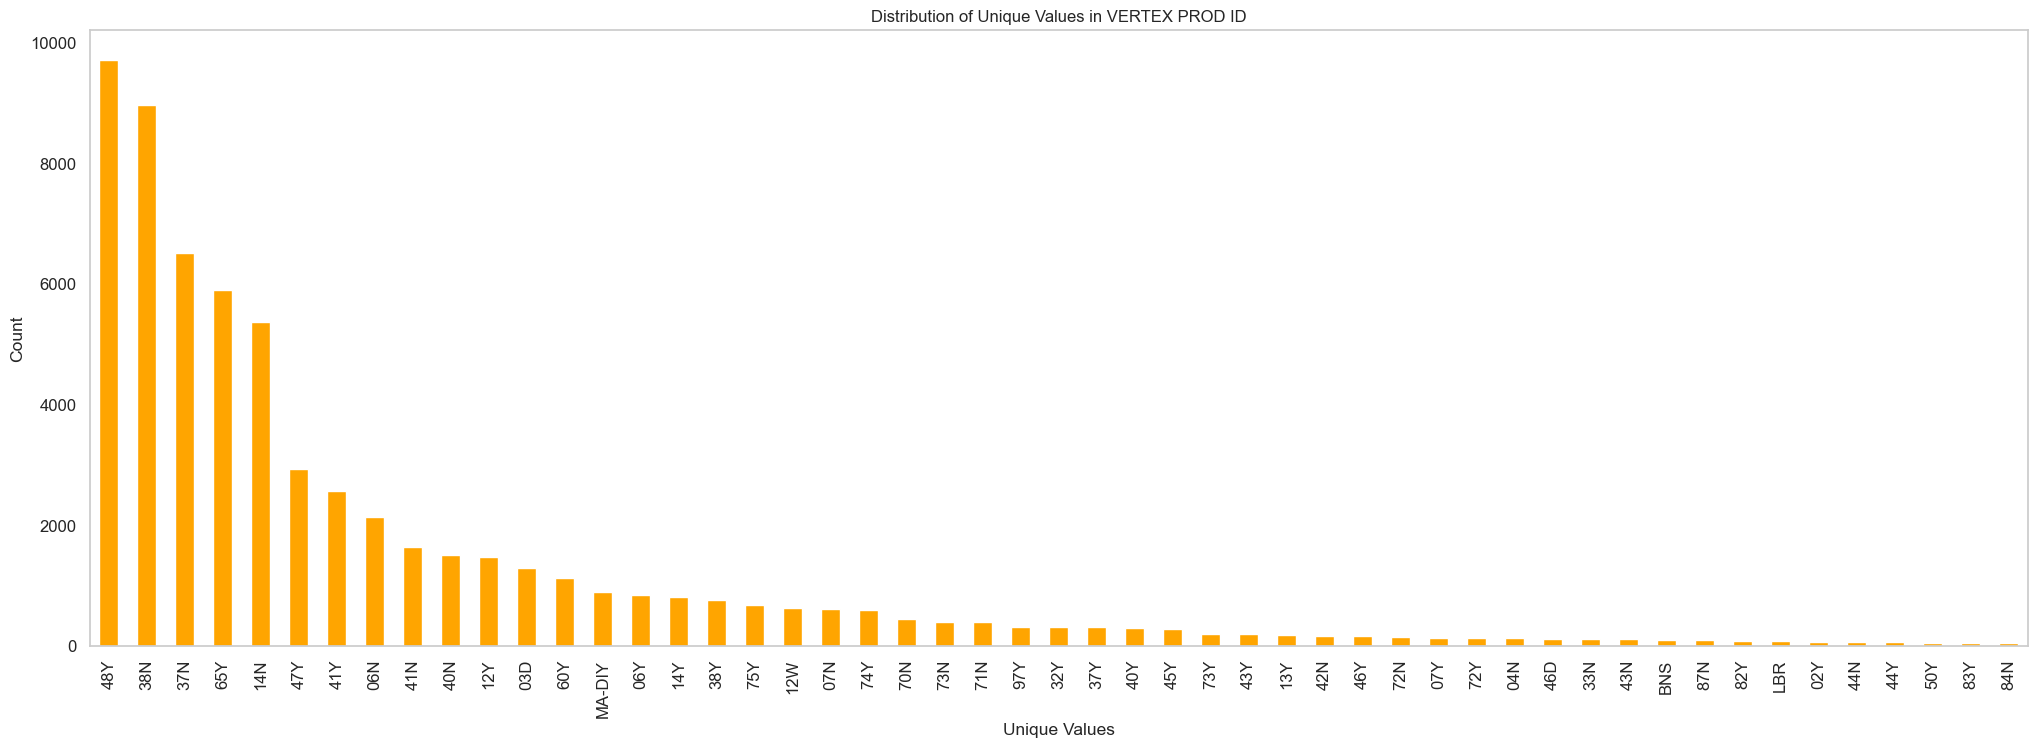

In [102]:
random_var = df_V2['VERTEX PROD ID'].value_counts()
random_var.plot(kind='bar',figsize=[25,8], color='orange')

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in VERTEX PROD ID')

# Show the plot
plt.grid()
plt.show()

In [103]:
#Create a copy of the dataframe and transform NaN values to Missing for ordinal encoding
encoBalance_df = df_V2.copy()
encoBalance_df.fillna('MISS', inplace=True)

ordinal_encodeBal = {}
encoded_dfBal = pd.DataFrame()



# Fit and transform data, and store ordinal encoders
for col in encoBalance_df.iloc[:, 1:].columns:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=9000)
    encoded_dfBal[col] = encoder.fit_transform(encoBalance_df[[col]]).flatten()
    ordinal_encodeBal[col] = encoder

In [104]:
# Save all ordinal encoders in a single file
joblib.dump(ordinal_encodeBal, 'ordinal_encoders.joblib')

['ordinal_encoders.joblib']

In [105]:
encoded_dfBal[columns_encoded] = encoded_dfBal[columns_encoded].astype(int)

---
--- 
# <CENTER>**PCA**</CENTER>

In [106]:
#Defino el número de componentes que quiero conservar
pca = PCA(n_components=22)
Scaler = StandardScaler()

In [107]:
#Separo X y Y
X_Scaled = encoded_dfBal.drop('VERTEX PROD ID', axis=1)
y_Scaled = encoded_dfBal['VERTEX PROD ID']

#Escalo X
X_Scaled = Scaler.fit_transform(X_Scaled)

#Convierto los datos en un dataframe-
X_Scaled = pd.DataFrame(X_Scaled)

In [108]:
X_trainScl, X_testScl, y_trainScl, y_testScl = train_test_split(X_Scaled, y_Scaled, test_size=0.2, random_state=42, stratify=y_Scaled)

X_train_pca = pca.fit_transform(X_trainScl)
X_test_pca = pca.transform(X_testScl)

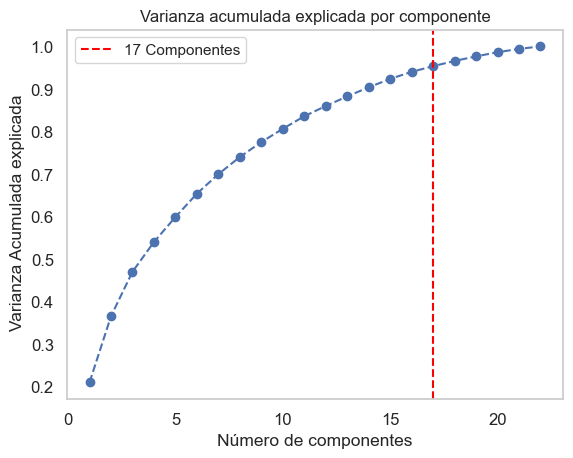

In [109]:
# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Find the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axvline(n_components, color='red', linestyle='--', label=f'{n_components} Componentes')
plt.xlabel('Número de componentes')
plt.ylabel(' Varianza Acumulada explicada')
plt.title('Varianza acumulada explicada por componente')
plt.legend()
plt.grid()
plt.show()


In [110]:
pca = PCA(n_components=17)

X_train_pca = pca.fit_transform(X_trainScl)
X_test_pca = pca.transform(X_testScl)

In [111]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_trainScl)

RandomForestClassifier(random_state=42)

In [112]:
predicted_y = rf_model.predict(X_test_pca)

# Evaluo la precisión
accuracy = balanced_accuracy_score(y_testScl, predicted_y)
print(f"Accuracy: {accuracy}")

# Escribir el informe en una variable
PCA_RF = classification_report(y_testScl, predicted_y, zero_division=float('NaN'))
print("\nReporte de clasificación:")
print(PCA_RF)
 
# Escribir el informe en un archivo
with open('PCA_RF.txt', 'w') as file:
    file.write(PCA_RF)

Accuracy: 0.9429034890614387

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.92      0.89      0.91       261
           2       0.67      0.23      0.34        26
           3       1.00      0.98      0.99       428
           4       0.94      0.98      0.96       170
           5       0.85      0.97      0.90       123
           6       0.93      1.00      0.97        28
           7       0.98      0.97      0.98       128
           8       0.98      0.85      0.91       296
           9       0.97      0.95      0.96        38
          10       0.99      1.00      0.99      1075
          11       0.97      0.92      0.95       163
          12       0.91      0.95      0.93        63
          13       1.00      0.91      0.95        23
          14       0.99      0.98      0.98      1303
          15       1.00      0.94      0.97        63
          16       0.98  

Después de aplicar el PCA se obtiene un balanced accuracy de 0.94, sin embargo para obtener esta puntuación es necesario mantener 17 componentes, lo cual no hace una gran diferencia a nivel computacional en el tiempo de predicción o en el tiempo de ejecución del modelo. De igual manera un PCA con este conjunto de datos con solo 24 variables no es necesario. Y emplearlo en este caso de negocio implicaría hacer una transformación adicional sobre los datos cada vez que se quieran hacer predicciones. Dado todo lo anterior, concluimos que para el caso de negocio y en vista de la reducida cantidad de variables y el bajo beneficio que se obtendría de un proceso de reducción de dimensionalidad como este, aplicar PCA es innecesario y decidimos prescindir del uso del mismo.

---
--- 
# <CENTER>**BALANCEO DE DATOS CON SMOTE**</CENTER>

In [113]:
df_without_null = encoded_dfBal.dropna()

In [114]:
X_SMOTE = df_without_null.drop('VERTEX PROD ID', axis=1)
y_SMOTE = df_without_null['VERTEX PROD ID']

# Split the data into training and testing sets
X_train_SM, X_test_SM, y_train_SM, y_test_SM = train_test_split(X_SMOTE, y_SMOTE, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_SM, y_train_SM)

# Create a new balanced DataFrame
df_balanced_SM = pd.concat([pd.DataFrame(X_train_resampled, columns=X_SMOTE.columns), pd.Series(y_train_resampled, name='VERTEX PROD ID')], axis=1)

In [115]:
clf_balanced_data = RandomForestClassifier(n_estimators=100,random_state=42)
clf_balanced_data = clf_balanced_data.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones
y_pred_sm = clf_balanced_data.predict(X_test_SM)

# Calcular la precisión del clasificador
accuracy = balanced_accuracy_score(y_test_SM, y_pred_sm)
print(f"Precisión del clasificador: {accuracy:.4f}")

# Escribir el informe en una variable
Smote_RF = classification_report(y_test_SM, y_pred_sm, zero_division=float('NaN'))
print("\nReporte de clasificación:")
print(Smote_RF)
 
# Escribir el informe en un archivo
with open('SMOTE_RF.txt', 'w') as file:
    file.write(Smote_RF)

Precisión del clasificador: 0.9537

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      0.93      0.93       252
           2       0.38      0.62      0.47        34
           3       1.00      0.99      0.99       423
           4       0.96      0.99      0.97       176
           5       0.88      0.72      0.79       127
           6       0.95      0.95      0.95        20
           7       0.98      0.98      0.98       131
           8       1.00      0.83      0.91       302
           9       0.74      0.97      0.84        33
          10       1.00      1.00      1.00      1049
          11       0.99      1.00      1.00       150
          12       0.91      0.95      0.93        61
          13       1.00      1.00      1.00        21
          14       1.00      0.98      0.99      1309
          15       0.95      0.97      0.96        64
          16       

---
--- 
# <CENTER>**PROCESO SIN PCA - CONJUNTO DE DATOS TRANSFORMADO (53 CLASES)**</CENTER>

In [116]:
XBal = encoded_dfBal.drop('VERTEX PROD ID', axis = 1)
yBal = encoded_dfBal['VERTEX PROD ID']

X_trainBal, X_testBal, y_trainBal, y_testBal = train_test_split(XBal, yBal, test_size=0.2, random_state=42, stratify=yBal)

In [117]:
clfBal = RandomForestClassifier(n_estimators=100,random_state=42)
clfBal = clfBal.fit(X_trainBal, y_trainBal)

# Realizar predicciones
y_pred = clfBal.predict(X_testBal)

# Calcular la precisión del clasificador
accuracy = balanced_accuracy_score(y_testBal, y_pred)
print(f"Precisión del clasificador: {accuracy:.4f}")

# Escribir el informe en un archivo
reportclfBal = classification_report(y_testBal, y_pred, zero_division=float('NaN'))
with open('ReportclfBal.txt', 'w') as file:
    file.write(reportclfBal)

Precisión del clasificador: 0.9526


# <CENTER> **XGBOOST CON CONJUNTO DE DATOS TRANSFORMADO** </CENTER>

In [118]:
#XG Boost
model = xgb.XGBClassifier()
model.fit(X_trainBal, y_trainBal)

y_pred = model.predict(X_testBal)

accuracy = balanced_accuracy_score(y_testBal, y_pred)
print(f"Precisión del clasificador: {accuracy:.4f}")

# Escribir el informe en un archivo
reportXGBal = classification_report(y_testBal, y_pred, zero_division=float('NaN'))
with open('ReportXGBal.txt', 'w') as file:
    file.write(reportXGBal)

Precisión del clasificador: 0.9418


# <CENTER> **BAGGING BASADO EN ÁRBOLES - CONJUNTO DE DATOS TRANSFORMADO** </CENTER>

In [119]:
# Crear un clasificador base (en este caso, un árbol de decisión)
base_classifier = DecisionTreeClassifier(random_state=42)

# Crear el clasificador Bagging usando el clasificador base
bagging_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

# Entrenar el clasificador Bagging
bagging_classifier.fit(X_trainBal, y_trainBal)

# Realizar predicciones en el conjunto de prueba
predictions = bagging_classifier.predict(X_testBal)

# Calcular la precisión
accuracy = balanced_accuracy_score(y_testBal, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Escribir el informe en un archivo
reportBaggingBal = classification_report(y_testBal, predictions, zero_division=float('NaN'))
with open('ReportBaggingBal.txt', 'w') as file:
    file.write(reportBaggingBal)

Accuracy: 0.9512


# <CENTER> **BAGGING BASADO EN ÁRBOLES - CON SMOTE** </CENTER>

In [120]:
# Crear un clasificador base (en este caso, un árbol de decisión)
base_classifier2 = DecisionTreeClassifier(random_state=42)

# Crear el clasificador Bagging usando el clasificador base
bagging_classifier2 = BaggingClassifier(base_classifier2, n_estimators=10, random_state=42)

# Entrenar el clasificador Bagging
bagging_classifier2.fit(X_train_SM, y_train_SM)

# Realizar predicciones en el conjunto de prueba
predictions2 = bagging_classifier2.predict(X_test_SM)

# Calcular la precisión
accuracy = balanced_accuracy_score(y_test_SM, predictions2)
print(f"Accuracy: {accuracy:.4f}")

# Escribir el informe en un archivo
reportBagging_SM = classification_report(y_test_SM, predictions2, zero_division=float('NaN'))
with open('reportBagging_SM.txt', 'w') as file:
    file.write(reportBagging_SM)

Accuracy: 0.9494


# <center> **VALIDACIÓN DEL MEJOR MODELO** </center>

In [121]:
# Random Forest - datos con todas las clases
ruta_archivo = 'ReportRF.txt'
MetricsRF = pd.read_csv(ruta_archivo, delimiter='\t')
 
def separa_col(dataframe):
    nuevas_columnas = dataframe[dataframe.columns[0]].str.split(expand=True)
# Asigna las nuevas columnas al DataFrame original
    dataframe['No'] = nuevas_columnas[0]
    dataframe['Precision'] = nuevas_columnas[1]
    dataframe['Recall'] = nuevas_columnas[2]
    dataframe['F1score'] = nuevas_columnas[3]
    dataframe['Support'] = nuevas_columnas[4]
 
# Elimina la columna original
    dataframe.drop(columns=[dataframe.columns[0]], inplace=True)
 
separa_col(MetricsRF)
 
MetricsRF = MetricsRF.iloc[:-3].astype(float)

In [122]:
# XGBoost - datos con la clase MA-DIY
ruta_archivo = 'ReportXGBal.txt'
MetricsXGBal = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsXGBal)
 
MetricsXGBal = MetricsXGBal.iloc[:-3].astype(float)

In [123]:
# Bagging - datos con la clase MA-DIY
ruta_archivo = 'ReportBaggingBal.txt'
MetricsBaggingBal = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsBaggingBal)
 
MetricsBaggingBal = MetricsBaggingBal.iloc[:-3].astype(float)

In [124]:
# Random Forest - datos con la clase MA-DIY
ruta_archivo = 'ReportclfBal.txt'
MetricsclfBal = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsclfBal)
 
MetricsclfBal = MetricsclfBal.iloc[:-3].astype(float)

In [125]:
# PCA - datos con la clase MA-DIY
ruta_archivo = 'PCA_RF.txt'
MetricsPCA = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsPCA)
 
MetricsPCA = MetricsPCA.iloc[:-3].astype(float)

In [126]:
# SMOTE - datos con la clase MA-DIY
ruta_archivo = 'SMOTE_RF.txt'
MetricsSmote = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsSmote)
 
MetricsSmote = MetricsSmote.iloc[:-3].astype(float)

In [127]:
# SMOTE - BAGGING
ruta_archivo = 'reportBagging_SM.txt'
MetricsSMOTE_BG = pd.read_csv(ruta_archivo, delimiter='\t')
 
separa_col(MetricsSMOTE_BG)
 
MetricsSMOTE_BG = MetricsSMOTE_BG.iloc[:-3].astype(float)

# **PRECISION SCORE**

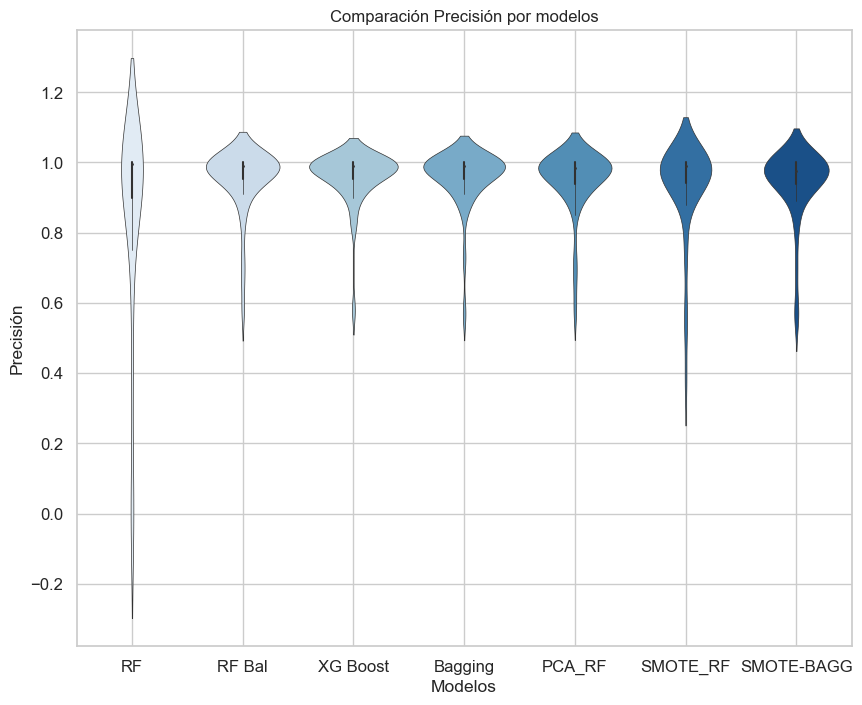

In [128]:
PrecisionTodos = pd.concat([MetricsRF['Precision'],MetricsclfBal['Precision'],MetricsXGBal['Precision'],MetricsBaggingBal['Precision'],MetricsPCA['Precision'],MetricsSmote['Precision'], MetricsSMOTE_BG['Precision']],axis=1)
PrecisionTodos = PrecisionTodos.dropna()
PrecisionTodos.columns = ['RF','RF Bal','XG Boost','Bagging','PCA_RF', 'SMOTE_RF', 'SMOTE-BAGG']
 
# Cambiar la tipografía en Seaborn
sns.set(font='Times New Roman',  # Cambia la fuente del texto
        rc={
            'axes.labelsize': 12.5,  # Tamaño de la etiqueta de los ejes
            'xtick.labelsize': 12,  # Tamaño de las etiquetas del eje x
            'ytick.labelsize': 12  # Tamaño de las etiquetas del eje y
        })
sns.set_style("whitegrid")
# Crear el boxplot con seaborn
plt.figure(figsize=(10, 8))  # Tamaño del gráfico opcional
sns.violinplot(data=PrecisionTodos, linewidth=0.5, edgecolor='blue', palette='Blues')
plt.title('Comparación Precisión por modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

In [129]:
PrecisionTodos.describe()

,RF,RF Bal,XG Boost,Bagging,PCA_RF,SMOTE_RF,SMOTE-BAGG
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.838095,0.952143,0.961429,0.958571,0.950238,0.931190,0.940476
std,0.314078,0.092302,0.074099,0.080655,0.090297,0.136206,0.102575
min,0.000000,0.580000,0.580000,0.570000,0.580000,0.380000,0.560000
25%,0.900000,0.952500,0.952500,0.952500,0.940000,0.942500,0.940000
50%,0.995000,0.990000,0.990000,0.990000,0.985000,0.990000,0.975000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **RECALL SCORE**

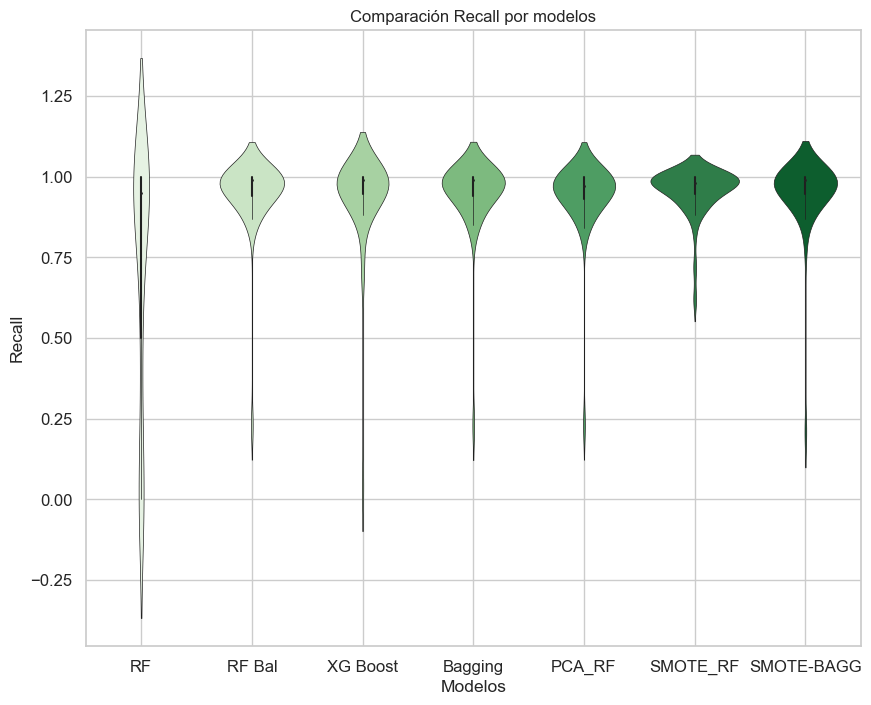

In [130]:
RecallTodos = pd.concat([MetricsRF['Recall'],MetricsclfBal['Recall'],MetricsXGBal['Recall'],MetricsBaggingBal['Recall'],MetricsPCA['Recall'],MetricsSmote['Recall'],MetricsSMOTE_BG['Recall']],axis=1)
RecallTodos = RecallTodos.dropna()
RecallTodos.columns = ['RF','RF Bal','XG Boost','Bagging','PCA_RF', 'SMOTE_RF', 'SMOTE-BAGG']
 
# Cambiar la tipografía en Seaborn
sns.set(font='Times New Roman',  # Cambia la fuente del texto
        rc={
            'axes.labelsize': 12.5,  # Tamaño de la etiqueta de los ejes
            'xtick.labelsize': 12,  # Tamaño de las etiquetas del eje x
            'ytick.labelsize': 12  # Tamaño de las etiquetas del eje y
        })
sns.set_style("whitegrid")
# Crear el boxplot con seaborn
plt.figure(figsize=(10, 8))  
sns.violinplot(data=RecallTodos, linewidth=0.5, edgecolor='blue', palette='Greens')
#sns.stripplot(data=PrecisionTodos, color="Black", size=4, jitter=True)  # scatter plot
plt.title('Comparación Recall por modelos')
plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

In [131]:
RecallTodos.describe()

,RF,RF Bal,XG Boost,Bagging,PCA_RF,SMOTE_RF,SMOTE-BAGG
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.721489,0.951702,0.940638,0.950213,0.943191,0.955745,0.950851
std,0.396835,0.115501,0.149498,0.116759,0.115516,0.073477,0.119670
min,0.000000,0.230000,0.040000,0.230000,0.230000,0.620000,0.210000
25%,0.500000,0.940000,0.945000,0.940000,0.930000,0.945000,0.945000
50%,0.950000,0.990000,0.990000,0.990000,0.970000,0.980000,0.990000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **F1 SCORE**

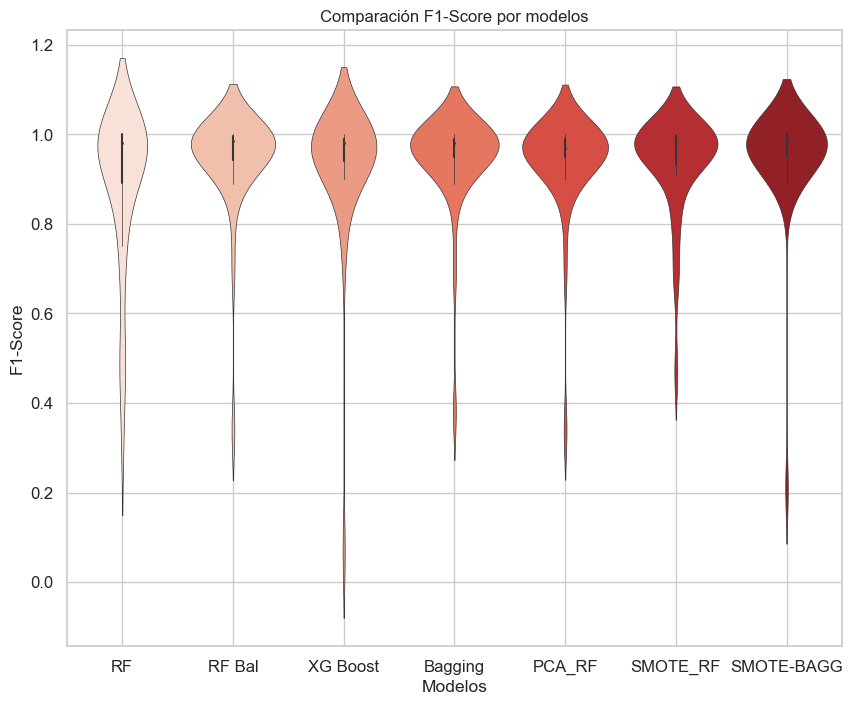

In [132]:
F1Todos = pd.concat([MetricsRF['F1score'],MetricsclfBal['F1score'],MetricsXGBal['F1score'],MetricsBaggingBal['F1score'],MetricsPCA['F1score'],MetricsSmote['F1score'],MetricsSMOTE_BG['Recall']],axis=1)
F1Todos = F1Todos.dropna()
F1Todos.columns = ['RF','RF Bal','XG Boost','Bagging','PCA_RF', 'SMOTE_RF', 'SMOTE-BAGG']
 
# Cambiar la tipografía en Seaborn
sns.set(font='Times New Roman',  # Cambia la fuente del texto
        rc={
            'axes.labelsize': 12.5,  # Tamaño de la etiqueta de los ejes
            'xtick.labelsize': 12,  # Tamaño de las etiquetas del eje x
            'ytick.labelsize': 12  # Tamaño de las etiquetas del eje y
        })
sns.set_style("whitegrid")
# Crear el boxplot con seaborn
plt.figure(figsize=(10, 8))  
sns.violinplot(data=F1Todos, linewidth=0.5, edgecolor='blue', palette='Reds')
plt.title('Comparación F1-Score por modelos')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.grid(True)
plt.show()

In [138]:
F1Todos.describe()

,RF,RF Bal,XG Boost,Bagging,PCA_RF,SMOTE_RF,SMOTE-BAGG
count,38.000000,38.00000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.891316,0.94500,0.932895,0.945000,0.939211,0.935526,0.952105
std,0.176515,0.11666,0.155458,0.111082,0.115159,0.110861,0.128403
min,0.320000,0.34000,0.070000,0.380000,0.340000,0.470000,0.210000
25%,0.892500,0.94250,0.940000,0.950000,0.950000,0.935000,0.952500
50%,0.980000,0.98500,0.980000,0.980000,0.970000,0.980000,0.985000
75%,1.000000,0.99750,0.990000,0.990000,0.990000,0.997500,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


# <center> **CROSS VALIDATION RANDOMFOREST - SMOTE** </center>

In [133]:
# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [10, 50, 100, 250, 300],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 7 ,10, 13],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=clfBal, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_SM, y_train_SM)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Mejores hiperparámetros encontrados:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


In [134]:
# Obtener el modelo con los mejores hiperparámetros y evaluar en el conjunto de prueba
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test_SM)
accuracy = balanced_accuracy_score(y_test_SM, predictions)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

Precisión en el conjunto de prueba: 0.9475


# <center> **CROSS VALIDATION BAGGING - SMOTE (OPCIONAL)** </center>

In [135]:
'''base_estimator = DecisionTreeClassifier(random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [10, 50, 100, 250, 300],
    'max_samples': [0.5, 0.7, 0.3, 1.0],  # Fracción de muestras usadas para cada iteración
    'max_features': [0.5, 0.7, 0.3, 1.0],  # Fracción de características usadas
    'bootstrap': [True, False],  # ¿Las muestras son tomadas con reemplazo?
    'bootstrap_features': [True, False]  # Las características son tomadas con reemplazo?
}

#Crear el clasificador
bagging_clf = BaggingClassifier(base_estimator=base_estimator, random_state=42)

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_bagging = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_bagging.fit(X_train_SM, y_train_SM)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search_bagging.best_params_)'''

'base_estimator = DecisionTreeClassifier(random_state=42)\n\n# Definir los hiperparámetros a buscar\nparam_grid = {\n    \'n_estimators\': [10, 50, 100, 250, 300],\n    \'max_samples\': [0.5, 0.7, 0.3, 1.0],  # Fracción de muestras usadas para cada iteración\n    \'max_features\': [0.5, 0.7, 0.3, 1.0],  # Fracción de características usadas\n    \'bootstrap\': [True, False],  # ¿Las muestras son tomadas con reemplazo?\n    \'bootstrap_features\': [True, False]  # Las características son tomadas con reemplazo?\n}\n\n#Crear el clasificador\nbagging_clf = BaggingClassifier(base_estimator=base_estimator, random_state=42)\n\n# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV\ngrid_search_bagging = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)\ngrid_search_bagging.fit(X_train_SM, y_train_SM)\n\n# Mostrar los mejores hiperparámetros encontrados\nprint("Mejores hiperparámetros encontrados:")\nprint(grid_search_bagging.best_params_)'

In [136]:
'''# Obtener el modelo con los mejores hiperparámetros y evaluar en el conjunto de prueba
best_bagging = grid_search_bagging.best_estimator_
predictions_bagging = best_bagging.predict(X_test_SM)
accuracy = balanced_accuracy_score(y_test_SM, predictions_bagging)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")'''

'# Obtener el modelo con los mejores hiperparámetros y evaluar en el conjunto de prueba\nbest_bagging = grid_search_bagging.best_estimator_\npredictions_bagging = best_bagging.predict(X_test_SM)\naccuracy = balanced_accuracy_score(y_test_SM, predictions_bagging)\nprint(f"Precisión en el conjunto de prueba: {accuracy:.4f}")'

# <center> **ENTRENAMIENTO DEL MEJOR MODELO OBTENIDO** </center>

In [139]:
#Se usa todo el conjunto de datos remuestreado con SMOTE para evitar que las clases minoritarias estén por fuera de los datos de entrenamiento del modelo
Final = RandomForestClassifier(random_state=42, max_depth= 20, min_samples_leaf= 1, min_samples_split=2, n_estimators=250)
Final = Final.fit(X_SMOTE, y_SMOTE)

model_filename = r"Final_model.pkl"
joblib.dump(Final, model_filename)

['Final_model.pkl']